In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
warnings.simplefilter('ignore')

We import a clone of hdmpy to use rlasso functions in python
```
!pip install multiprocess
!pip install pyreadr
!git clone https://github.com/maxhuppertz/hdmpy.git
```

In [3]:
!pip install multiprocess
!pip install pyreadr
!git clone https://github.com/maxhuppertz/hdmpy.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 6.3 MB/s eta 0:00:00
Cloning into 'hdmpy'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 70 (delta 39), reused 52 (delta 21), pack-reused 0
Receiving objects: 100% (70/70), 25.30 KiB | 5.06 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [4]:
import sys
sys.path.insert(1, "./hdmpy")
import hdmpy

In [5]:
# An estimator class that runs the lasso with theoretically driven penalty choice.
# Better in small samples than cross-validation and also faster computationally
class RLasso(BaseEstimator):

    def __init__(self, *, post=False):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    @property
    def coef_(self):
        return np.array(self.rlasso_.est['beta']).flatten()

    def predict(self, X):
        return X @ self.coef_ + np.array(self.rlasso_.est['intercept'])

In [6]:
# A simple experimental data generating process. No effect heterogeneity.
def gen_data(n, d, p, delta, base):
    X = np.random.normal(0, 1, size=(n, d))
    D = np.random.binomial(1, p, size=(n,))
    y0 = base - X[:, 0] + np.random.normal(0, .1, size=(n,))
    y1 = delta + base - X[:, 0] + np.random.normal(0, .1, size=(n,))
    y = y1 * D + y0 * (1 - D)
    return y, D, X

In [7]:
n = 100 # n samples
d = 100 # n features
delta = 1.0 # treatment effect
base = .3 # baseline outcome

In [8]:
# Simple two means estimate and calculation of variance
def twomeans(y, D):
    hat0 = np.mean(y[D==0]) # mean of outcome of un-treated
    hat1 = np.mean(y[D==1]) # mean of outcome of treated
    V0 = np.var(y[D==0]) / np.mean(1 - D) # asymptotic variance of the mean of outcome of untreated
    V1 = np.var(y[D==1]) / np.mean(D) # asymptotic variance of the mean of outcome of treated
    hat = hat1 - hat0 # estimate of effect
    stderr = np.sqrt((V0 + V1) / n) # standard error of estimate of effect
    return hat, stderr

In [9]:
np.random.seed(123)
y, D, X = gen_data(n, d, .2, delta, base) # generate RCT data
twomeans(y, D) # calculate estimation quantities

(0.8018889598126377, 0.2469727302839426)

In [10]:
from sklearn.linear_model import LinearRegression
# We implement the partialling out version of OLS (for pedagogical purposes)
def partialling_out(y, D, W):
    yres = y - LinearRegression().fit(W, y).predict(W) # residualize outcome with OLS
    Dres = D - LinearRegression().fit(W, D).predict(W) # residualize treatment with OLS
    hat = np.mean(yres * Dres) / np.mean(Dres**2) # calculate final residual ~ residual ols estimate
    epsilon = yres - hat * Dres # calculate residual of final regression; epsilon in the BLP decomposition
    V = np.mean(epsilon**2 * Dres**2) / np.mean(Dres**2)**2 # calculate variance of effect
    return hat, np.sqrt(V / y.shape[0]) # return estimate and standard error

In [11]:
partialling_out(y, D, np.hstack([D*X, X]))

(0.34072529769158266, 0.06930800733485254)

In [12]:
# Now we simply replace OLS with Lasso to implement the Double Lasso process
def double_lasso(y, D, W):
    yres = y - RLasso().fit(W, y).predict(W) # residualize outcome with Lasso
    Dres = D - RLasso().fit(W, D).predict(W) # residualize treatment with Lasso
    # rest is the same as in the OLS case
    hat = np.mean(yres * Dres) / np.mean(Dres**2)
    epsilon = yres - hat * Dres
    V = np.mean(epsilon**2 * Dres**2) / np.mean(Dres**2)**2
    return hat, np.sqrt(V / y.shape[0])

In [13]:
double_lasso(y, D, np.hstack([D*X, X]))

(0.9951576009987022, 0.04469042128095983)

In [14]:
# We now check the distributional properties of the different estimators across experiments
# First is the simple two means estimate
cov, hats, stderrs = [], [], [] # we will keep track of coverage (truth is in CI) and of the point estimate and stderr
for _ in range(100):
    y, D, X = gen_data(n, d, .2, delta, base)
    hat, stderr = twomeans(y, D)
    ci = [hat - 1.96 * stderr, hat + 1.96 * stderr] # 95% confidence interval
    hats += [hat]
    stderrs += [stderr]
    cov += [(ci[0] <= delta) & (delta <= ci[1])] # 1 if CI contains the true parameter

In [15]:
np.mean(cov) # average coverage (should be .95 ideally)

0.96

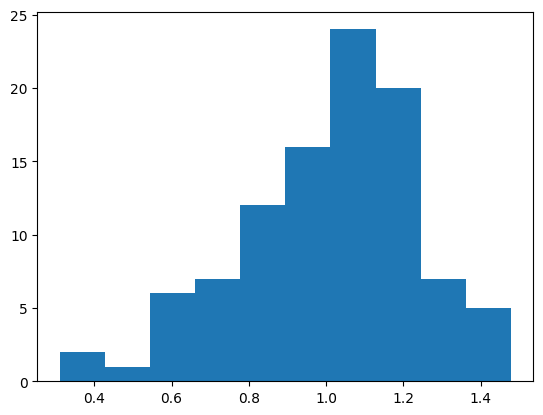

In [16]:
# distribution of estimates
plt.hist(hats)
plt.show()

In [17]:
np.mean(hats) # mean of estimate; measures how biased the estimate is (should be =delta ideally)

1.004605573753389

In [18]:
np.std(hats) # standard deviation of estimates; should be close to the standard errors we calculated for the CIs

0.22134842744604127

In [19]:
np.mean(stderrs)

0.23873338367929242

In [20]:
# Let's repeat this for the partialling out process (OLS), controlling for X
cov, hats, stderrs = [], [], [] # we will keep track of coverage (truth is in CI) and of the point estimate and stderr
for _ in range(100):
    y, D, X = gen_data(n, d, .2, delta, base)
    hat, stderr = partialling_out(y, D, X)
    ci = [hat - 1.96 * stderr, hat + 1.96 * stderr] # 95% confidence interval
    hats += [hat]
    stderrs += [stderr]
    cov += [(ci[0] <= delta) & (delta <= ci[1])] # 1 if CI contains the true parameter

In [21]:
np.mean(cov)

0.25

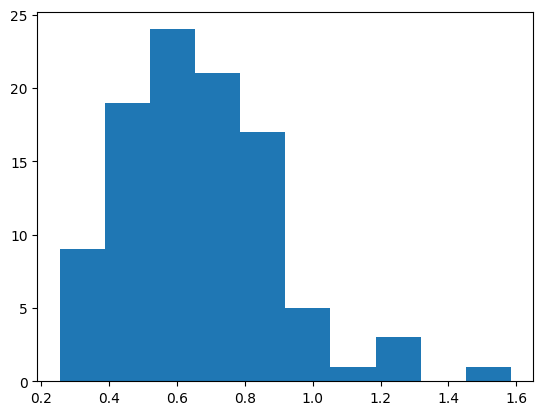

In [22]:
plt.hist(hats)
plt.show()

In [23]:
np.mean(hats) # ols is heavily biased... mean of estimates very far from delta=1

0.6648896979606153

In [24]:
np.std(hats)

0.23252375403167425

In [25]:
np.mean(stderrs) # standard error severely under estimates the variance of the estimate; all this is due to overfitting

0.1131703370473928

In [26]:
# Now let's try the double Lasso. Because it's computationally expensive
# we'll do the experiments in parallel. Python makes parallelism very simple
from joblib import Parallel, delayed # we import these two functions

# we wrap our experiment process in a function, which is supposed to run a
# a single experiment
def exp(it, n, d):
    np.random.seed(it) # we draw a different seed for each experiment
    y, D, X = gen_data(n, d, .2, delta, base) # we generate data
    hat, stderr = double_lasso(y, D, X) # we apply the double lasso process
    ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
    # return estimate, standard error and (1 if CI contains the true parameter)
    return hat, stderr, (ci[0] <= delta) & (delta <= ci[1])

# Now here is how you run any function in parallel multiple times
# It's a simple parallel for loop.
res = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, n, d) for it in range(100))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.8s finished


In [27]:
# This simply takes the list of triples and turns it into a triple of lists :)
# good trick to know
hats, stderrs, cov = zip(*res)

In [28]:
np.mean(cov) # much better coverage than OLS

0.91

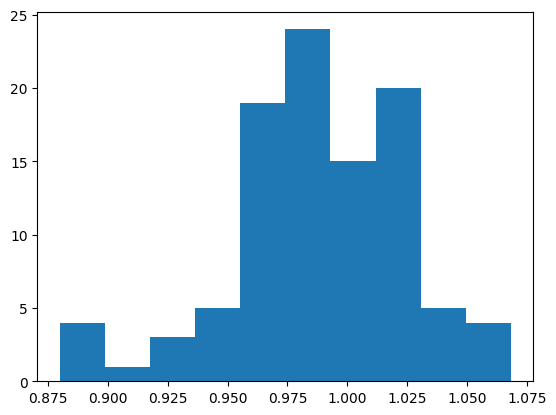

In [29]:
plt.hist(hats)
plt.show()

In [30]:
np.mean(hats) # much closer to 1... (almost the same as two-means)

0.9885129415998108

In [31]:
np.std(hats) # standard deviation much smaller than two means, which did not adjust for X

0.03594508729115616

In [32]:
np.mean(stderrs) # and close to the calculate standard errors; we correctly estimated uncertainty

0.03399510356178103

In [33]:
# Let's see what would happen if we just run a single lasso
from joblib import Parallel, delayed

def exp(it, n, d):
    np.random.seed(it)
    y, D, X = gen_data(n, d, .2, delta, base)
    hat = RLasso().fit(np.hstack([D.reshape(-1, 1), X]), y).coef_[0]
    return hat # no obvious way to account for uncertainty

res = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, n, d) for it in range(100))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.6s finished


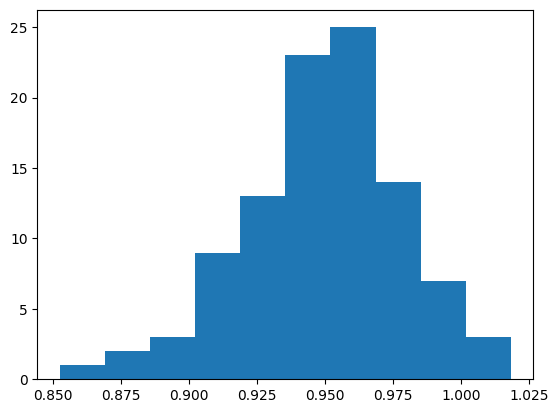

In [34]:
plt.hist(res)
plt.show()

In [35]:
# bias is comparable and larger than standard deviation.
# Even if we could estimate the standard deviation, confidence intervals would undercover
1 - np.mean(res), np.std(res)

(0.050475677805303154, 0.028884200739207194)

In [36]:
# Let's try adding a post-Lasso OLS step and construct confidence
# intervals ignoring the Lasso step
from joblib import Parallel, delayed

def exp(it, n, d):
    np.random.seed(it)
    y, D, X = gen_data(n, d, .2, delta, base)
    # run a big lasso y ~ D, X
    DX = np.hstack([D.reshape(-1, 1), X])
    coefs = RLasso().fit(DX, y).coef_[1:]
    # run OLS on y ~ D, X[chosen by lasso]
    # calculate standard error as if lasso step never happened
    hat, stderr = partialling_out(y, D - np.mean(D), X[:, np.abs(coefs)>0.0])
    ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
    return hat, stderr, (ci[0] <= delta) & (delta <= ci[1])

res = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, n, d) for it in range(100))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.8s finished


In [38]:
hats, stderrs, cov = zip(*res)

In [39]:
np.mean(cov) # not bad

0.84

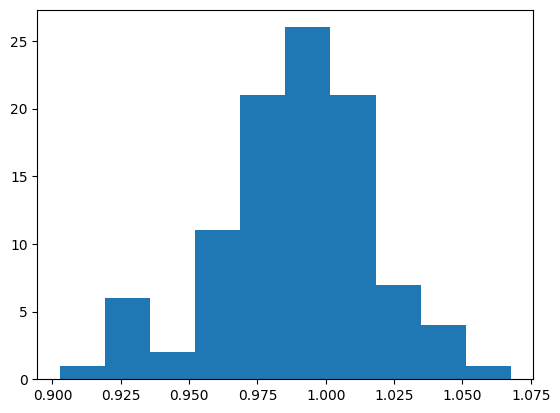

In [40]:
plt.hist(hats)
plt.show()

In [41]:
1 - np.mean(hats), np.std(hats) # quite un-biased; bias < standard deviation

(0.010426863603987369, 0.02935721315771419)

In [42]:
# we under-estimated a bit the uncertainty; smaller estimated stderr than true std.
# this is most prob a finite sample error, from ignoring the lasso variable selection step
# this is an RCT and so even post lasso ols is Neyman orthogonal. We should expect good behavior.
np.mean(stderrs)

0.021836912547711952

In [43]:
# But what if we are not in an RCT!?
import scipy.special
def gen_data(n, d, p, delta, base):
    X = np.random.normal(0, 1, size=(n, d))
    D = X[:, 0] + np.random.normal(0, 1/4, size=(n,))
    y = delta * D + base - X[:, 0] + np.random.normal(0, 1, size=(n,))
    return y, D, X

In [44]:
from joblib import Parallel, delayed

def exp(it, n, d):
    np.random.seed(it)
    y, D, X = gen_data(n, d, .2, delta, base)
    DX = np.hstack([D.reshape(-1, 1), X])
    coefs = RLasso().fit(DX, y).coef_[1:]
    hat, stderr = partialling_out(y, D, X[:, np.abs(coefs)>0.0])
    ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
    return hat, stderr, (ci[0] <= delta) & (delta <= ci[1])

res = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, n, d) for it in range(100))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.4s finished


In [45]:
hats, stderrs, cov = zip(*res)

In [46]:
np.mean(cov) # Oops! Post Lasso OLS severely undercovers; It is not Neyman orthogonal when D is correlated with X

0.06

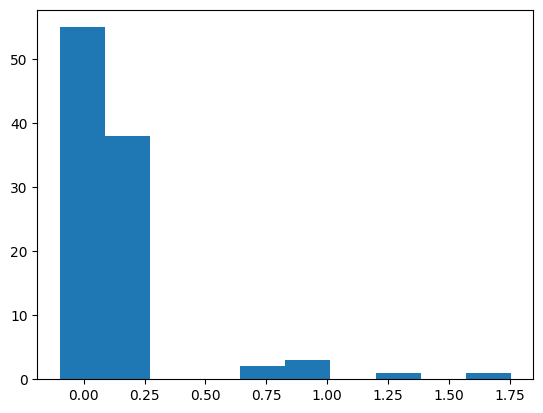

In [47]:
plt.hist(hats)
plt.show()

In [48]:
np.mean(hats) # very heavily biased

0.13314746199317987

In [49]:
# But let's try the Neyman orthogonal Double Lasso
from joblib import Parallel, delayed

def exp(it, n, d):
    np.random.seed(it)
    y, D, X = gen_data(n, d, .2, delta, base)
    hat, stderr = double_lasso(y, D, X) # we apply the double lasso process
    ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
    return hat, stderr, (ci[0] <= delta) & (delta <= ci[1])

res = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, n, d) for it in range(100))
hats, stderrs, cov = zip(*res)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.8s finished


In [50]:
np.mean(cov) # great coverage

0.92

In [51]:
1 - np.mean(hats), np.std(hats) # very small bias compared to standard deviation

(-0.012935262655555224, 0.4208056138818759)

In [52]:
np.mean(stderrs) # accurate estimation of uncertainty

0.3910698115940304

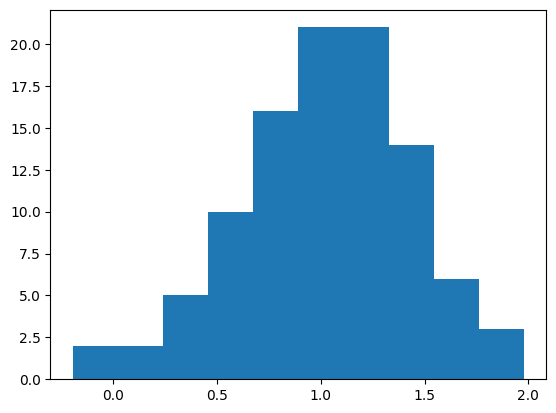

In [53]:
# Approximately normal distribution of estimates, centered at the truth
plt.hist(hats)
plt.show()